In [1]:
!pip install datasets -q

In [2]:
from datasets import load_dataset
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

print(tf.__version__)

2023-09-08 01:20:13.625304: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 01:20:13.671154: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 01:20:13.968061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 01:20:13.970640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 01:20:15.372250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.13.0


In [3]:
dataset = load_dataset('nanyy1025/covid_fake_news')
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/joseph-vunanga/.cache/huggingface/datasets/nanyy1025___csv/nanyy1025--covid_fake_news-389e2fecc7fefa61/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 6420
    })
    validation: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
    test: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
})

In [4]:
train_texts = dataset['train']['tweet']
train_labels = dataset['train']['label']

test_texts = dataset['test']['tweet']
test_labels = dataset['test']['label']

validation_texts = dataset['validation']['tweet']
validation_labels = dataset['validation']['label']

print(len(train_texts))
print(len(test_texts))
print(len(validation_texts))

6420
2140
2140


In [5]:
df = pd.DataFrame()
df['text'] = train_texts + test_texts + validation_texts
df['label'] = train_labels + test_labels + validation_texts
df


,text,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real
...,...,...
10695,Donald Trump wrongly claimed that New Zealand ...,Donald Trump wrongly claimed that New Zealand ...
10696,Current understanding is #COVID19 spreads most...,Current understanding is #COVID19 spreads most...
10697,Nothing screams “I am sat around doing fuck al...,Nothing screams “I am sat around doing fuck al...
10698,Birx says COVID-19 outbreak not under control ...,Birx says COVID-19 outbreak not under control ...


-----------------------------------------

In [6]:
def encoding(label):
  return 1 if label == 'real' else 0

df['y'] =df['label'].apply(lambda x: encoding(x))

In [7]:
df['text'] = df['text'].str.replace('[^\w\s]', '') # removing punctuation
df['text'] = df['text'].str.replace('\d+', '') # removing numbers
df['text'] = df['text'].str.replace('@', '') # removing leading whitespace '@'
df['text'] = df['text'].str.replace('#', '') # removing trailing '#'
df['text'] = df['text'].str.replace('\s+', ' ') # removing extra whitespace
df['text'] = df['text'].str.lower() # lowercase

df.head()

,text,label,y
0,the cdc currently reports 99031 deaths. in gen...,real,1
1,states reported 1121 deaths a small rise from ...,real,1
2,politically correct woman (almost) uses pandem...,fake,0
3,indiafightscorona: we have 1524 covid testing ...,real,1
4,populous states can generate large case counts...,real,1


In [8]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['y'], test_size=0.2, random_state=42)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_seq = tokenizer.texts_to_sequences(train_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)


In [10]:
print(len(train_seq[1]))
print(len(train_seq[5]))
print(len(train_seq[20]))

26
51
10


In [11]:
max_seq_length = max(max(map(len, train_seq)),max(map(len, train_seq)) )
print(max_seq_length)

1492


In [12]:
train_data = pad_sequences(train_seq, maxlen = max_seq_length)
test_data = pad_sequences(test_seq, maxlen = max_seq_length)

In [13]:
print('GPU available: ', tf.config.list_physical_devices('GPU'))

GPU available:  []


In [14]:
model = Sequential()

model.add(Embedding(len(tokenizer.word_index)+1, 100, input_length = max_seq_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss= 'binary_crossentropy', optimizer ='adam', metrics=['accuracy'])

In [16]:
history = model.fit(train_data, train_labels, validation_data=(test_data,test_labels), epochs=6, batch_size=64)

Epoch 1/6
134/134 [==============================] - 190s 1s/step - loss: 0.4659 - accuracy: 0.7668 - val_loss: 0.3772 - val_accuracy: 0.8407
Epoch 2/6
134/134 [==============================] - 203s 2s/step - loss: 0.2649 - accuracy: 0.8912 - val_loss: 0.3977 - val_accuracy: 0.8327
Epoch 3/6
134/134 [==============================] - 182s 1s/step - loss: 0.1005 - accuracy: 0.9639 - val_loss: 0.5237 - val_accuracy: 0.8290
Epoch 4/6
134/134 [==============================] - 173s 1s/step - loss: 0.0344 - accuracy: 0.9882 - val_loss: 0.7913 - val_accuracy: 0.7771
Epoch 5/6
134/134 [==============================] - 171s 1s/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.8973 - val_accuracy: 0.8075
Epoch 6/6
134/134 [==============================] - 170s 1s/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.8292 - val_accuracy: 0.8000


In [17]:
loss, acc = model.evaluate(test_data, test_labels)
print(loss)
print(acc)

67/67 [==============================] - 17s 259ms/step - loss: 0.8292 - accuracy: 0.8000
0.8292050957679749
0.800000011920929


In [18]:
import matplotlib.pyplot as plt

def plot(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epoch")
  plt.ylabel(string)
  plt.show()

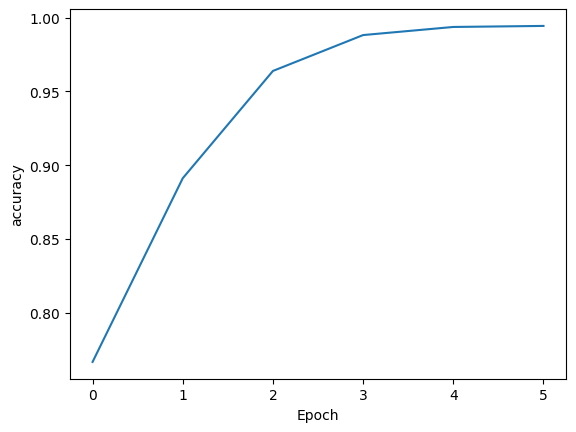

In [19]:
plot(history, 'accuracy')

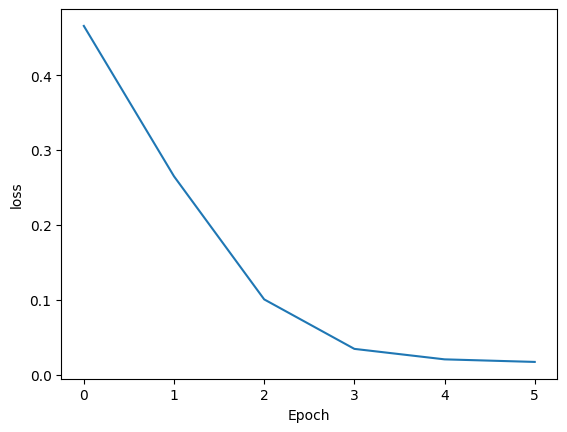

In [20]:
plot(history, 'loss')

In [21]:
import numpy as np

def classify_text(model, tokenizer, text):
  seq = tokenizer.texts_to_sequences([text])
  seq =  pad_sequences(seq, maxlen = model.input_shape[1])

  pred = model.predict(seq)
  pred_label = np.round(pred(0).astype(int))

  if pred_label == 0:
    return "fake news"
  else:
    return "real news"